# Import modules

In [86]:
import os 
import numpy as np
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
from matplotlib import pyplot as plt
import matplotlib.colors as mcolor
import seaborn as sb
import random
import matplotlib.patches as mpatches
from Robert_functions import *

# Code

In [126]:
# general parameters for the workflow

# define csv file that contains the database (without the .csv extension) and the response value
w_dir = os.getcwd()

# name of the csv containing the database without the CSV extension. For example: csv_name = 'Phenolic_data' 
csv_name = 'Robert_example'

# name of the csv file that will contain the optimal parameters
name_csv_hyperopt = 'Predictor_parameters'

# specify the response value (y), for example: response_value = 'activation_barrier_kcal/mol'
response_value = 'Target_values'

# specify columns of the csv to drop from the descriptors but to keep in the final database
# (i.e. reaction names). For example: fixed_descriptors = ['Name','SMILES','YSI/MW','YSI','CN','MW','weakest_bondtype'].
# If there are not descriptors to discard, just use fixed_descriptors = []
fixed_descriptors = ['Name']

# convert columns with strings into categorical values using 1,2,3... (alternative
# to one-hot encoding that the code uses by default)
categorical_mode = False

# activate with correlation_filter = True
correlation_filter = True

# threshold values for the correlation filters (if correlation_filter = True)
correlation_y_threshold = 0.02 # (only use descriptors that correlate with R**2 > 0.02 with the response value)
correlation_x_threshold = 0.85 # (only use descriptors that don't correlate with R**2 > 0.85 with other descriptors)

# training set proportion
training_size = [60,70,80,90] # relative to the training set proportion (i.e. 40 = 40% training data)

# mode for splitting data. Methods available:
# 1. k-neighbours clustering-based splitting (KN)
# 2. random splitting (RND)
split_mode = 'KN'

# parameters to be optimized. Different types of regressor models are supported:
# 1. Random forests ('RF')
# 2. Multivariate lineal models ('MVL')
# 3. Gradient boosting ('GB')
# 4. AdaBoost regressor ('AdaB')
# 5. MLP regressor neural network ('NN')    
# 6. Voting regressor combining RF, GB and NN ('VR')
model_type = ['RF','GB']

# type of prediction:
# 1. Regressor ('reg')
# 2. Classifier ('clas')    
prediction_type = 'reg'

# random seed used in the ML predictor models
random_init = 0

# Number of epochs for the hyperopt optimization
n_epochs = 5

# sets the number of times a feature is randomly shuffled and returns a sample of feature importances (standard from Sklearn webpage: 30)
n_repeats = 30

# the PFI filter is X% of the model's score (% adjusted with per_cent_PFI_filter, 0.04 = 4%)
# WARNING! For regression, a value of 0.04 is recommended. For classification, 
# a value of 0 is recommended. Turn this option off with PFI_filtering = False
PFI_filtering = True
if prediction_type == 'reg':
    per_cent_PFI_filter = 0.04
if prediction_type == 'clas':
    per_cent_PFI_filter = 0

# number of k-folds for cross validation
cv_kfold = 5


In [62]:
# remove correlated variables and noise (variables that do not correlate with the y values)

DFT_parameters = pd.read_csv(csv_name+'.csv')

# converts all columns with strings into categorical values (one hot encoding
# by default, can be set to numerical 1,2,3... with categorical_mode = True).
# Troubleshooting! For one-hot encoding, don't use variable names that are
# also column headers! 9I.E. DESCRIPTOR "C_atom" contain C2 as a value,
# but C2 is already a header of a different column in the database. Same applies
# for multiple columns containing the same variable names.

descriptors_to_drop = []
for column in DFT_parameters.columns:
    if column not in fixed_descriptors:
        if(DFT_parameters[column].dtype == 'object'):
            descriptors_to_drop.append(column)
            if categorical_mode:
                
                DFT_parameters[column] = DFT_parameters[column].astype('category')
                DFT_parameters[column] = DFT_parameters[column].cat.codes
            else:
                labels = DFT_parameters[column].unique()
                dummies = pd.get_dummies(DFT_parameters[column])
                DFT_parameters_filtered = DFT_parameters.drop(column, axis=1)
                DFT_parameters = pd.concat([DFT_parameters, dummies], axis=1)

if correlation_filter:
    descriptors_to_drop = correlation_filter_fun(DFT_parameters,correlation_y_threshold,correlation_x_threshold,fixed_descriptors,descriptors_to_drop,response_value)

# this parts allows to drop any descriptor that we don't want to use
DFT_parameters_filtered = DFT_parameters.drop(descriptors_to_drop, axis=1)

print('\nSuccessfully created '+ str(len(DFT_parameters[response_value])) + ' datapoints.\n')
print('\nDescriptors used after correlation filters:')

DFT_parameters_filter_print = DFT_parameters_filtered.drop(fixed_descriptors, axis=1)
for _,column in enumerate(DFT_parameters_filter_print.columns):
    if column != response_value:
        print(column)


Excluded parameters:
x1 : R**2 = 1.0 with x3
x1 : R**2 = 0.96 with x6
x3 : R**2 = 0.95 with x6

Successfully created 37 datapoints.


Descriptors used after correlation filters:
x2
x5
x6
x7
x8
x9
x10
x11
Csub-Csub
Csub-H
Csub-O
H-O


In [4]:
# separate fixed descriptors and create X and y dataframes
fixed_data = DFT_parameters_filtered[fixed_descriptors]

fixed_descriptors.append(response_value)
X = DFT_parameters_filtered.drop(fixed_descriptors, axis=1)
y = DFT_parameters_filtered[response_value]

In [200]:
# data splitting into training and validation sets
    
if split_mode in ['KN','RND']:

    X_train, y_train, X_validation, y_validation, training_points = data_split(X,y,training_size,random_init,split_mode)

else:
    print('x  Select a valid method for splitting data (options: KN, RMD)!')
    sys.exit()

fixed_data_train = fixed_data.iloc[training_points]
fixed_data_validation = fixed_data.drop(training_points)
print(X_train)
# standardizes the data sets using the mean and standard dev from the train set
Xmean = X_train.mean(axis=0)
Xstd = X_train.std(axis=0)
X_train_scaled = (X_train - Xmean) / Xstd
X_validation_scaled = (X_validation - Xmean) / Xstd

TypeError: unsupported operand type(s) for /: 'list' and 'int'

100%|██████████| 5/5 [00:00<00:00, 15.05trial/s, best loss: 0.16145605724614776]

x  Warning! Error lower without PFI filter (no PFI: RMSE = 0.12 with 12 variables; with PFI filter: 0.16 with 3 variables) consider using PFI_filtering=False

The optimal model is RF with training size 60%



[]

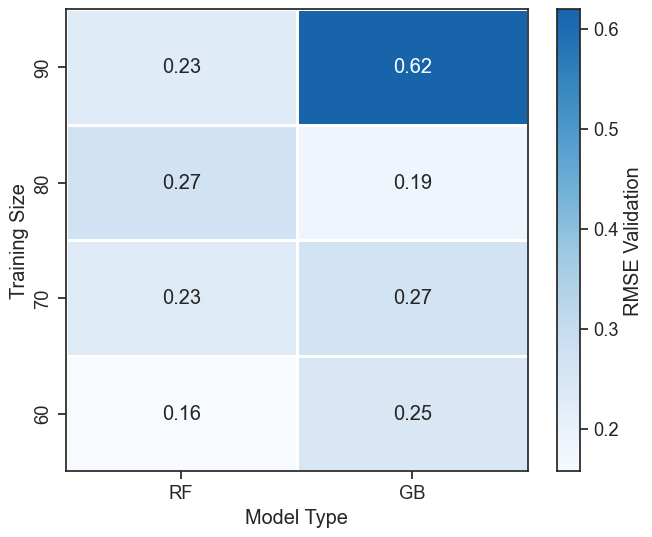

In [129]:
from Robert_functions import *
if training_size == ['all']:
    training_size = [90,80,70,60,50,40,30,20,10]
    
size_data= [ ]
for size in training_size:
    size_data_indiv = []
        
    if split_mode in ['KN','RND']:

        X_train, y_train, X_validation, y_validation, training_points = data_split(X,y,size,random_init,split_mode)

    else:
        print('x  Select a valid method for splitting data (options: KN, RMD)!')
        sys.exit()

    fixed_data_train = fixed_data.iloc[training_points]
    fixed_data_validation = fixed_data.drop(training_points)
    #print(X_train)
    # standardizes the data sets using the mean and standard dev from the train set
    Xmean = X_train.mean(axis=0)
    Xstd = X_train.std(axis=0)
    X_train_scaled = (X_train - Xmean) / Xstd
    X_validation_scaled = (X_validation - Xmean) / Xstd
    if model_type == ['all']:
        model_type = ['RF','GB','AdaB','MVL','NN','VR']
        
    models_data = []
    for MODEL in model_type:
        models_data_indiv = []
        # hyperopt process including k-neighbours-based splitting of the data
        hyperopt_process = run_hyperopt(n_epochs, MODEL, X, size, prediction_type, random_init, w_dir, X_train_scaled, y_train, X_validation_scaled, y_validation, name_csv_hyperopt)

        # read the csv to load and print information about the parameters
        best_parameters_df = pd.read_csv(name_csv_hyperopt+'.csv')
    
        # print information about the hyperopt process
        #print_hyperopt_params(MODEL,best_parameters_df,training_size,w_dir)
        if prediction_type == 'reg':
        # calculate R2, MAE and RMSE for train and validation sets
            r2_train,mae_train,rmse_train,r2_validation,mae_validation,rmse_validation,_,_ = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,prediction_type,size)
        # calculates k-fold cross validation
            cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,prediction_type,cv_kfold)
        # print stats
        # print_model_stats(MODEL,X_train_scaled,X_validation_scaled,r2_train,mae_train,rmse_train,r2_validation,mae_validation,rmse_validation,prediction_type,cv_score,cv_kfold,None)

        elif prediction_type == 'clas':
        # calculate accuracy, F1 score and MCC for train and validation sets
            accuracy_train,f1score_train,mcc_train,accuracy_validation,f1score_validation,mcc_validation,_,_ = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,prediction_type,size)
        # calculates k-fold cross validation
            cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,prediction_type,cv_kfold)
        # print stats
            #print_model_stats(MODEL,X_train_scaled,X_validation_scaled,accuracy_train,f1score_train,mcc_train,accuracy_validation,f1score_validation,mcc_validation,prediction_type,cv_score,cv_kfold,None)
        # calculate the permutation feature importance (PFI) of the descriptors in the 
        # model and generates a new dataset
        # print(rmse_validation)
        # PFI function
        combined_descriptor_list = PFI_workflow(X,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,n_repeats,per_cent_PFI_filter,False,prediction_type,PFI_filtering)

        # creates X and y sets
        # creates a database with the most important descriptors after PFI

        df_PFI_model = pd.DataFrame()
        df_PFI_model[response_value] = DFT_parameters_filtered[response_value]

        for i,column in enumerate(DFT_parameters_filtered.columns):
            if column in combined_descriptor_list:
                df_PFI_model[column] = DFT_parameters_filtered[column]

        X_PFI = df_PFI_model.drop([response_value], axis=1)
        y_PFI = df_PFI_model[response_value]

        # k-neighbours-based data splitting using previous training points
        X_train_PFI = X_PFI.iloc[training_points]
        y_train_PFI = y_PFI.iloc[training_points]
        X_validation_PFI = X_PFI.drop(training_points)
        y_validation_PFI = y_PFI.drop(training_points)

        # standardizes the data sets using the mean and standard dev from the train set
        Xmean = X_train_PFI.mean(axis=0)
        Xstd = X_train_PFI.std(axis=0)
        X_train_PFI_scaled = (X_train_PFI - Xmean) / Xstd
        X_validation_PFI_scaled = (X_validation_PFI - Xmean) / Xstd
        # run the best model from hyperopt and calculates its efficiency using only 
        # the most important features from the PFI analysis
        try:
            if int(best_parameters_df['max_features'][0]) > len(X_PFI.columns):
                best_parameters_df.at[0,'max_features'] = len(X_PFI.columns)
                # replace the value in the parameters csv
                export_param_excel = best_parameters_df.to_csv(name_csv_hyperopt+'.csv', index = None, header=True)
        except KeyError:
            pass

        if prediction_type == 'reg':
            # calculate R2, MAE and RMSE for train and validation sets
            r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,y_pred_train_PFI,y_pred_validation_PFI = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,prediction_type,size)
            # print(rmse_validation_PFI)
            # calculates k-fold cross validation
            cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,prediction_type,cv_kfold)
            # print stats
            #print_model_stats(MODEL,X_train_PFI_scaled,X_validation_PFI_scaled,r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,prediction_type,cv_score,cv_kfold,'Robert_results.txt')
            # data of the model
            models_data_indiv = [MODEL, best_parameters_df, r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,rmse_validation,X_train_PFI_scaled,X_train_scaled,y_pred_train_PFI,y_pred_validation_PFI, cv_score,X_validation_PFI_scaled,prediction_type,cv_kfold,'Robert_results.txt',y_train_PFI,y_validation_PFI]
        elif prediction_type == 'clas':
            # calculate accuracy, F1 score and MCC for train and validation sets
            accuracy_train_PFI,f1score_train_PFI,mcc_train_PFI,accuracy_validation_PFI,f1score_validation_PFI,mcc_validation_PFI,y_pred_train_PFI,y_pred_validation_PFI = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,prediction_type,size)
            # calculates k-fold cross validation
            cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,prediction_type,cv_kfold)
            # print stats
            #print_model_stats(MODEL,X_train_PFI_scaled,X_validation_PFI_scaled,accuracy_train_PFI,f1score_train_PFI,mcc_train_PFI,accuracy_validation_PFI,f1score_validation_PFI,mcc_validation_PFI,prediction_type,cv_score,cv_kfold,'Robert_results.txt')
            # data of the model
            models_data_indiv = [MODEL, best_parameters_df, accuracy_train_PFI,f1score_train_PFI,mcc_train_PFI,accuracy_validation_PFI,f1score_validation_PFI,mcc_validation_PFI,y_pred_train_PFI,y_pred_validation_PFI, cv_score]
            
        models_data.append(models_data_indiv)

    size_data_indiv = [size,models_data]
    size_data.append(size_data_indiv)

#Obtain the best model (<rmse_validation value)
print()
best_model = optimal_model(size_data)
df = pd.DataFrame(best_model[1])
df['Second'] = df["train_proportion"].astype(str).str.split().str[0]
print()
print(f"The optimal model is {best_model[0]} with training size {df['Second'][0]}")
print()
plot_data=[]
for models_data in size_data:
    plot_data_indv=0
    plot_data_indiv = []
    for rmse_validation_PFI in models_data[1]:  
        plot_data_indiv.append(rmse_validation_PFI[7])
    plot_data.append(plot_data_indiv)

#pd.DataFrame(models_data)
df_plot = pd.DataFrame(plot_data)
df_plot.columns = [model_type]
df_plot.index = [training_size]
df_plot = df_plot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(7.45,6))
# print(df_plot)
# sb.heatmap(df_plot, annot=True,linewidth=.5,cmap="crest")
sb.set(font_scale=1.2, style='ticks')
cmap_blues_75_percent_512 =  [mcolor.rgb2hex(c) for c in plt.cm.Blues(np.linspace(0, 0.8, 512))]
ax = sb.heatmap(df_plot, annot=True, linewidth=1, cmap=cmap_blues_75_percent_512, cbar_kws={'label': 'RMSE Validation'})
ax.set(xlabel="Model Type", ylabel="Training Size")
sb.despine(top=False, right=False)
plt.savefig('Benchmark_methods.png', dpi=600, bbox_inches='tight')
ax.plot()

Model: RF
k-neighbours-based training, validation and test sets have been created with this distribution:
Training points: 22
Validation points: 15

k-neighbours-based training: R2 = 0.97; MAE = 0.08; RMSE = 0.12
5-fold cross validation: 0.65 ± 0.22
k-neighbours-based validation: R2 = 0.96; MAE = 0.11; RMSE = 0.16

Permutation feature importances of the descriptors in the RF model (for the validation set). Only showing values that drop the original score at least by 0%:

Original score = 0.95
Csub-H: 0.47 ± 0.15
x5: 0.23 ± 0.08
Csub-Csub: 0.06 ± 0.02


c:\Users\David\Desktop\robert\Robert_functions.py:814: UserWarning: FixedFormatter should only be used together with FixedLocator
  


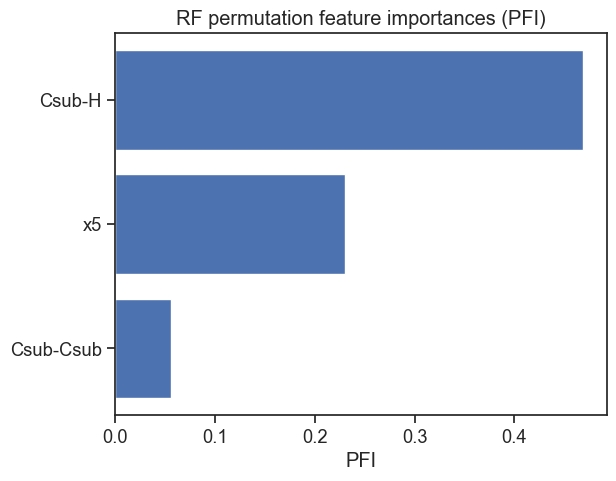

In [130]:
# run the best model from hyperopt and calculates its efficiency using only the most important features from the PFI analysis
#print_model_stats(MODEL,X_train_PFI_scaled,X_validation_PFI_scaled,r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,prediction_type,cv_score,cv_kfold,'Robert_results.txt')
print_model_stats(best_model[0],best_model[9],best_model[14],best_model[2],best_model[3],best_model[4],best_model[5],best_model[6],best_model[7],prediction_type,best_model[13],best_model[16],best_model[17])
# calculate the permutation feature importance (PFI) of the final model and saves the data
# combined_descriptor_list = PFI_workflow(X_PFI,model_type,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,n_repeats,0,True,prediction_type,PFI_filtering)
combined_descriptor_list = PFI_workflow(X_PFI,best_model[0],best_model[1],best_model[9],best_model[18],best_model[14],best_model[19],n_repeats,0,True,prediction_type,PFI_filtering)

In [205]:
# run the best model from hyperopt and calculates its efficiency

if prediction_type == 'reg':
    # calculate R2, MAE and RMSE for train and validation sets
    r2_train,mae_train,rmse_train,r2_validation,mae_validation,rmse_validation,_,_ = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,prediction_type,training_size)
    # calculates k-fold cross validation
    cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,prediction_type,cv_kfold)
    # print stats
    print_model_stats(MODEL,X_train_scaled,X_validation_scaled,r2_train,mae_train,rmse_train,r2_validation,mae_validation,rmse_validation,prediction_type,cv_score,cv_kfold,None)

elif prediction_type == 'clas':
    # calculate accuracy, F1 score and MCC for train and validation sets
    accuracy_train,f1score_train,mcc_train,accuracy_validation,f1score_validation,mcc_validation,_,_ = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,prediction_type,training_size)
    # calculates k-fold cross validation
    cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_scaled,y_train,prediction_type,cv_kfold)
    # print stats
    print_model_stats(MODEL,X_train_scaled,X_validation_scaled,accuracy_train,f1score_train,mcc_train,accuracy_validation,f1score_validation,mcc_validation,prediction_type,cv_score,cv_kfold,None)


Model: RF
k-neighbours-based training, validation and test sets have been created with this distribution:
Training points: 22
k-neighbours-based training: R2 = 0.99; MAE = 0.07; RMSE = 0.1
5-fold cross validation: 0.76 ± 0.12



In [203]:
# calculate the permutation feature importance (PFI) of the descriptors in the 
# model and generates a new dataset

# PFI function
combined_descriptor_list = PFI_workflow(X,MODEL,best_parameters_df,X_train_scaled,y_train,X_validation_scaled,y_validation,n_repeats,per_cent_PFI_filter,False,prediction_type,PFI_filtering)

# creates X and y sets
# creates a database with the most important descriptors after PFI

df_PFI_model = pd.DataFrame()
df_PFI_model[response_value] = DFT_parameters_filtered[response_value]

for i,column in enumerate(DFT_parameters_filtered.columns):
    if column in combined_descriptor_list:
        df_PFI_model[column] = DFT_parameters_filtered[column]

X_PFI = df_PFI_model.drop([response_value], axis=1)
y_PFI = df_PFI_model[response_value]

# k-neighbours-based data splitting using previous training points
X_train_PFI = X_PFI.iloc[training_points]
y_train_PFI = y_PFI.iloc[training_points]
X_validation_PFI = X_PFI.drop(training_points)
y_validation_PFI = y_PFI.drop(training_points)

# standardizes the data sets using the mean and standard dev from the train set
Xmean = X_train_PFI.mean(axis=0)
Xstd = X_train_PFI.std(axis=0)
X_train_PFI_scaled = (X_train_PFI - Xmean) / Xstd
X_validation_PFI_scaled = (X_validation_PFI - Xmean) / Xstd

In [212]:
# run the best model from hyperopt and calculates its efficiency using only 
# the most important features from the PFI analysis
if int(best_parameters_df['max_features'][0]) > len(X_PFI.columns):
    best_parameters_df.at[0,'max_features'] = len(X_PFI.columns)
    # replace the value in the parameters csv
    export_param_excel = best_parameters_df.to_csv(name_csv_hyperopt+'.csv', index = None, header=True)

if prediction_type == 'reg':
    # calculate R2, MAE and RMSE for train and validation sets
    r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,y_pred_train_PFI,y_pred_validation_PFI = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,prediction_type,training_size)
    # calculates k-fold cross validation
    cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,prediction_type,cv_kfold)
    # print stats
    print_model_stats(MODEL,X_train_PFI_scaled,X_validation_PFI_scaled,r2_train_PFI,mae_train_PFI,rmse_train_PFI,r2_validation_PFI,mae_validation_PFI,rmse_validation_PFI,prediction_type,cv_score,cv_kfold,'Robert_results.txt')

elif prediction_type == 'clas':
    # calculate accuracy, F1 score and MCC for train and validation sets
    accuracy_train_PFI,f1score_train_PFI,mcc_train_PFI,accuracy_validation_PFI,f1score_validation_PFI,mcc_validation_PFI,y_pred_train_PFI,y_pred_validation_PFI = predictor_workflow(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,prediction_type,training_size)
    # calculates k-fold cross validation
    cv_score = cross_val_calc(random_init,MODEL,best_parameters_df,X_train_PFI_scaled,y_train_PFI,prediction_type,cv_kfold)
    # print stats
    print_model_stats(MODEL,X_train_PFI_scaled,X_validation_PFI_scaled,accuracy_train_PFI,f1score_train_PFI,mcc_train_PFI,accuracy_validation_PFI,f1score_validation_PFI,mcc_validation_PFI,prediction_type,cv_score,cv_kfold,'Robert_results.txt')

5
Model: RF
k-neighbours-based training, validation and test sets have been created with this distribution:
Training points: 22
Validation points: 15

k-neighbours-based training: R2 = 0.97; MAE = 0.08; RMSE = 0.12
5-fold cross validation: 0.65 ± 0.22
k-neighbours-based validation: R2 = 0.96; MAE = 0.11; RMSE = 0.16



Permutation feature importances of the descriptors in the RF model (for the validation set). Only showing values that drop the original score at least by 0%:

Original score = 0.95
Csub-H: 0.47 ± 0.15
x5: 0.23 ± 0.08
Csub-Csub: 0.06 ± 0.02


c:\Users\David\Desktop\robert\Robert_functions.py:814: UserWarning: FixedFormatter should only be used together with FixedLocator
  


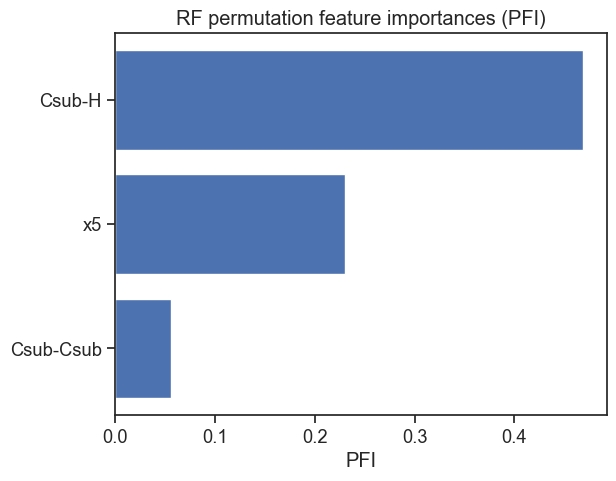

In [131]:
# calculate the permutation feature importance (PFI) of the final model and
# saves the data
# combined_descriptor_list = PFI_workflow(X_PFI,model_type,best_parameters_df,X_train_PFI_scaled,y_train_PFI,X_validation_PFI_scaled,y_validation_PFI,n_repeats,0,True,prediction_type,PFI_filtering)
combined_descriptor_list = PFI_workflow(X_PFI,best_model[0],best_model[1],best_model[9],best_model[18],best_model[14],best_model[19],n_repeats,0,True,prediction_type,PFI_filtering)

In [ ]:
# Save the data in a CSV file including set column and predicted values 

X_train_csv = fixed_data_train.copy()
X_validation_csv = fixed_data_validation.copy()

X_train_csv[response_value] = y_train_PFI
X_validation_csv[response_value] = y_validation_PFI

X_train_csv[f'Predicted {response_value}'] = y_pred_train_PFI
X_validation_csv[f'Predicted {response_value}'] = y_pred_validation_PFI

X_train_csv = pd.concat([X_train_csv, X_train_PFI], axis=1)
X_validation_csv = pd.concat([X_validation_csv, X_validation_PFI], axis=1)

X_train_csv['Set'] = 'Training'
X_validation_csv['Set'] = 'Validation'

df_csv = pd.concat([X_train_csv, X_validation_csv], axis=0)

# creates an Excel database with only the most important descriptors used by the model
export_param_excel = df_csv.to_csv(f'{csv_name}_final_dataset.csv', index = None, header=True)


In [ ]:
# Plot training and test sets

if prediction_type == 'reg':
    sb.set(font_scale=1.2, style="ticks") #set styling preferences

    Plotdata_train_PFI = {'y_train_PFI': y_train_PFI, 'y_pred_train_PFI': y_pred_train_PFI} 
    Plotdata_validation_PFI = {'y_validation_PFI': y_validation_PFI, 'y_pred_validation_PFI': y_pred_validation_PFI}

    df_train_PFI = pd.DataFrame.from_dict(Plotdata_train_PFI)
    df_validation_PFI = pd.DataFrame.from_dict(Plotdata_validation_PFI)

    # Build the plot
    # Set up some features to plot the dots
    color_train = 'b'
    color_validation = 'orange'
    size = 30
    alpha = 1 # from 0 (transparent) to 1 (opaque)

    # Create subplot with a certain size and title
    fig, ax = plt.subplots(figsize=(5,5))

    # Set styling preferences
    sb.set(font_scale=1.2, style="ticks")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    # title of the graph
    total_points = len(y_train_PFI)+len(y_validation_PFI)
    train_proportion = len(y_train_PFI)/total_points
    validation_proportion = len(y_validation_PFI)/total_points
    ratios =  str(round(train_proportion,2)*100)+':'+str(round(validation_proportion,2)*100)
    title_text = model_type+' model with train:validation ('+ratios+') of '+str(total_points)+' datapoints'
    
    plt.text(0.5, 1.08, title_text, horizontalalignment='center',
         fontsize=14, fontweight='bold', transform = ax.transAxes)

    # Plot the data
    points_train = ax.scatter(df_train_PFI["y_train_PFI"], df_train_PFI["y_pred_train_PFI"],
                c = color_train, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)

    points_validation = ax.scatter(df_validation_PFI["y_validation_PFI"], df_validation_PFI["y_pred_validation_PFI"],
                c = color_validation, s = size, edgecolor = 'k', linewidths = 0.8, alpha = alpha, zorder=2)

    # Put a legend below current axis
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.17),
            fancybox=True, shadow=True, ncol=5, labels=['Training','Validation'])

    # Add the regression line with a confidence interval based on the training sets
    plot = sb.regplot("y_train_PFI", "y_pred_train_PFI", data=df_train_PFI, scatter=False, color=".1", 
                    truncate = True, ax=ax)

    # Title of the axis
    plot = ax.set(ylabel=f'Predicted {response_value}', xlabel=f'{response_value} from database')
    
    # Add gridlines
    ax.grid(linestyle='--', linewidth=1)

    # set limits
    size_space = 0.1*abs(min(y_train_PFI)-max(y_train_PFI))
    if min(y_train_PFI) < min(y_validation_PFI):
        min_value_graph = min(y_train_PFI)-size_space
    else:
        min_value_graph = min(y_validation_PFI)-size_space
        
    if max(y_train_PFI) > max(y_validation_PFI):
        max_value_graph = max(y_train_PFI)+size_space
    else:
        max_value_graph = max(y_validation_PFI)+size_space
        
    plt.xlim(min_value_graph, max_value_graph)
    plt.ylim(min_value_graph, max_value_graph)
        
    # save the plot a png image, type True
    plt.savefig('Predicted vs database values.png', dpi=400, bbox_inches='tight')

    plt.show()

    print('\nThe corresponding graph was saved in '+w_dir+'.')

elif prediction_type == 'clas':
    predictor_model = predictor_model_fun(model_type, best_parameters_df, random_init, prediction_type)

    predictor_model.fit(X_train_PFI_scaled, y_train_PFI)

    plot_confusion_matrix(predictor_model, X_validation_PFI_scaled, y_validation_PFI,cmap='Blues') 
    plt.show()


In [ ]:
# run x- and y-shuffle statistical tests
random.seed(a=random_init)

# load original data
df_tests_model = pd.read_csv(csv_name+'_final_dataset.csv')

training_data = df_tests_model[df_tests_model.Set == 'Training']
validation_data = df_tests_model[df_tests_model.Set == 'Validation']

# parameters to discard from the csv
shuffle_drops = fixed_descriptors.copy()
shuffle_drops.append('Set')
shuffle_drops.append('Predicted '+response_value)

X_train_tests = training_data.drop(shuffle_drops, axis=1)
X_validation_tests = validation_data.drop(shuffle_drops, axis=1)

y_train_tests = training_data[response_value]
y_validation_tests = validation_data[response_value]

# standardizes the data sets using the mean and standard dev from the train set
Xmean_tests = X_train_tests.mean(axis=0)
Xstd_tests = X_train_tests.std(axis=0)
X_train_tests_scaled = (X_train_tests - Xmean) / Xstd
X_validation_tests_scaled = (X_validation_tests - Xmean) / Xstd

y_train_tests = training_data[response_value]
y_validation_tests = validation_data[response_value]

# x shuffle test
X_train_shuffled = training_data.drop(shuffle_drops, axis=1)
X_validation_shuffled = validation_data.drop(shuffle_drops, axis=1)

# fixed_descriptors
X_train_shuffled = np.asarray(X_train_shuffled)
X_validation_shuffled = np.asarray(X_validation_shuffled)

# standardizes the data sets using the mean and standard dev from the train set
Xmean = X_train_shuffled.mean(axis=0)
Xstd = X_train_shuffled.std(axis=0)
X_train_shuffled_scaled = (X_train_shuffled - Xmean) / Xstd
X_validation_shuffled_scaled = (X_validation_shuffled - Xmean) / Xstd

for row in X_train_shuffled_scaled:
    random.shuffle(row)
    random.shuffle(row)
    random.shuffle(row)
    
for row in X_validation_shuffled_scaled:
    random.shuffle(row)
    random.shuffle(row)
    random.shuffle(row)

print('\nResults from the x-shuffle test')
r2_train_tests,mae_train_tests,rmse_train_tests,r2_validation_tests,mae_validation_tests,rmse_validation_tests,y_pred_train_tests,y_pred_validation_tests = predictor_workflow(random_init,model_type,best_parameters_df,X_train_shuffled_scaled,y_train_tests,X_validation_shuffled_scaled,y_validation_tests,prediction_type,training_size)
cv_score_x_shuffle = cross_val_calc(random_init,model_type,best_parameters_df,X_train_shuffled_scaled,y_train_tests,prediction_type,cv_kfold)
print_model_stats(model_type,X_train_tests_scaled,X_validation_tests_scaled,r2_train_tests,mae_train_tests,rmse_train_tests,r2_validation_tests,mae_validation_tests,rmse_validation_tests,prediction_type,cv_score_x_shuffle,cv_kfold,'Robert_results_x-shuffle.txt')

# y shuffle test
y_train_shuffled = y_train_tests.copy()
y_validation_shuffled = y_validation_tests.copy()

y_train_shuffled = np.asarray(y_train_shuffled)   
y_validation_shuffled = np.asarray(y_validation_shuffled) 

random.shuffle(y_train_shuffled)
random.shuffle(y_validation_shuffled)

print('\nResults from the y-shuffle test')
r2_train_tests,mae_train_tests,rmse_train_tests,r2_validation_tests,mae_validation_tests,rmse_validation_tests,y_pred_train_tests,y_pred_validation_tests = predictor_workflow(random_init,model_type,best_parameters_df,X_train_tests_scaled,y_train_shuffled,X_validation_tests_scaled,y_validation_shuffled,prediction_type,training_size)
cv_score_y_shuffle = cross_val_calc(random_init,model_type,best_parameters_df,X_train_tests_scaled,y_train_shuffled,prediction_type,cv_kfold)
print_model_stats(model_type,X_train_tests_scaled,X_validation_tests_scaled,r2_train_tests,mae_train_tests,rmse_train_tests,r2_validation_tests,mae_validation_tests,rmse_validation_tests,prediction_type,cv_score_y_shuffle,cv_kfold,'Robert_results_y-shuffle.txt')
